In [380]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import norm, t, ttest_1samp, ttest_rel, ttest_ind, zscore
import matplotlib.pyplot as plt

### Population Distribution

In [2]:
# FUNCTION 1
def logit(x, position = 0.5, spread = -20, setoff = 0, altitude = 1):
    return (1/(1+np.exp(spread * (x - position)))) * altitude + setoff

# FUNCTION 2
def gauss(x, position = 0.5, deviation = 0.1, height = 0, altitude = 1):
    return (np.exp(-np.power(x - position, 2.) / (2 * np.power(deviation, 2.))) + height) * altitude

# FUNCTION 3
def winner(x, position = None):
    xPoints = np.linspace(0, 1, 5)
    yPoints = [1, 0, 0.5, 0, 1]
    h = interp1d(xPoints, yPoints)
    return h(x)

# FUNCTION 4
def sine(x, position = 0.5):
    return (np.sin(10*x + position))*0.5+0.5

functions = [logit, gauss, winner, sine]

In [3]:
def generateDistribution(function, size=1):
    if size==1:
        x = np.random.rand()
        y = function(x)
        if np.random.rand() <= y:
            return x
        return generateDistribution(function)
    else:
        return np.array([generateDistribution(function) for _ in range(size)])

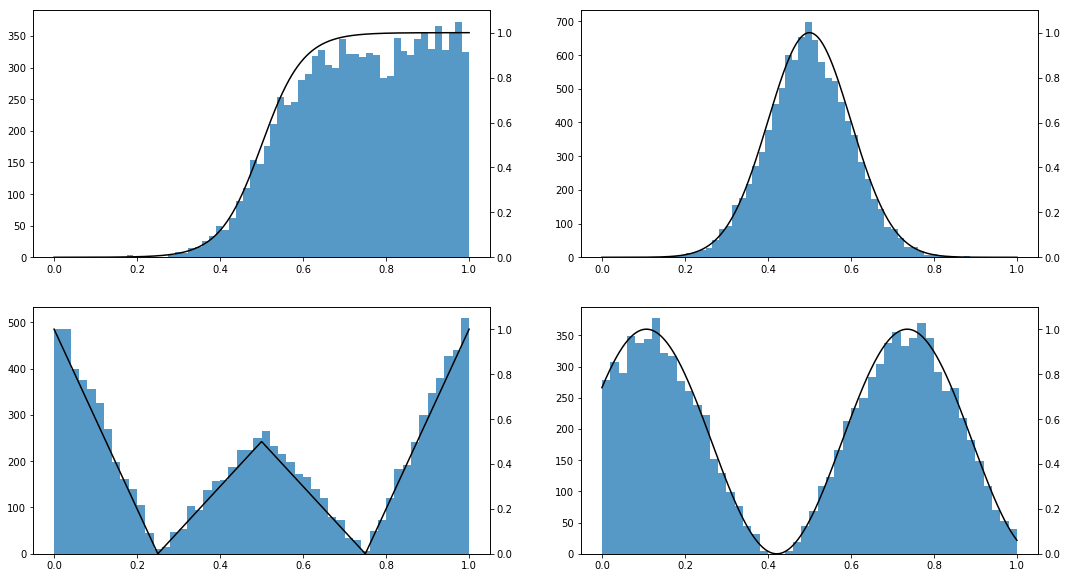

In [4]:
x = np.linspace(0, 1, num=1000)
fig = plt.figure(figsize=(18, 10))
mean, sd = [], []
for i, f in enumerate(functions):
    ax = fig.add_subplot(221+i); ax2 = ax.twinx()
    population = generateDistribution(f, 10000)
    ax.hist(population, bins=50, alpha=0.75)
    mean.append(population.mean())
    sd.append(np.std(population))
    ax2.plot(x, f(x), '-k'); ax2.set_ylim(0,1.1)
    #ax2.fill_between(x, 0, f(x), alpha=0.2)
plt.show()

### Sampling Distribution

In [5]:
SIZE = 5
SAMPLES = 10000
ZSCORE = 1.96

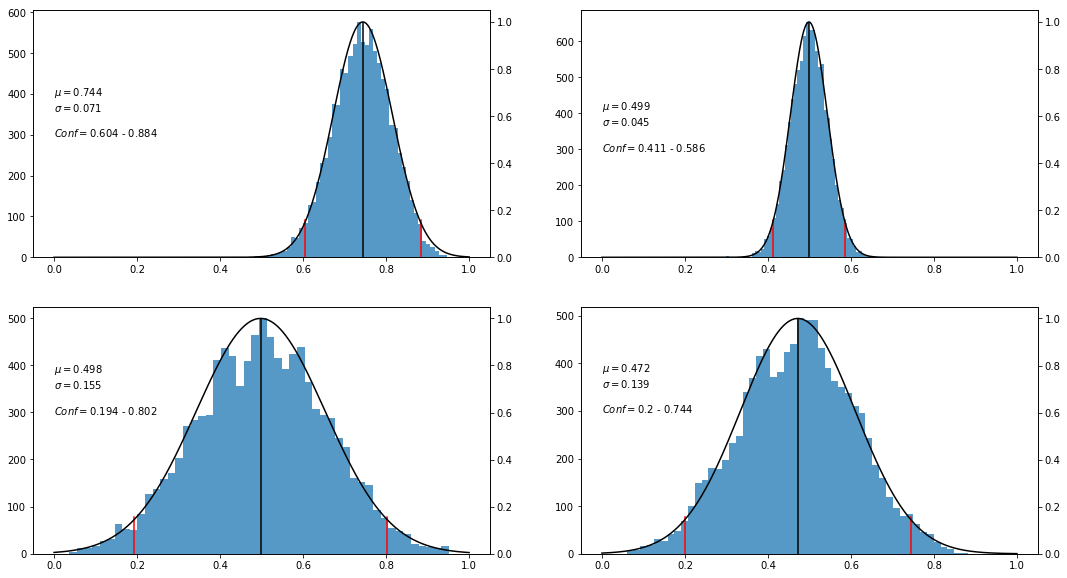

In [6]:
x = np.linspace(0, 1, num=1000)
fig = plt.figure(figsize=(18, 10))
for i, f in enumerate(functions):
    ax = fig.add_subplot(221+i); ax2 = ax.twinx()
    
    samplemeans = [generateDistribution(f, SIZE).mean() for _ in range(SAMPLES)]
    se = sd[i] / np.sqrt(SIZE)
    ci = (mean[i]-ZSCORE*se, mean[i]+ZSCORE*se) # = norm.interval(0.95, mean[i], se)
    
    ax.hist(samplemeans, bins=50, alpha=0.75)
    ax2.plot(x, gauss(x, mean[i], se), '-k'); ax2.set_ylim(0,)
    ax.text(0, 300, r'$\mu =$' + str(round(mean[i], 3)) + '\n' + r'$\sigma =$' + str(round(se, 3)) +
            '\n\n' + r'$Conf = $' + str(round(ci[0], 3)) + ' - ' + str(round(ci[1], 3)))
    
    ax.axvline(x=ci[0], color='r', ymax=0.15)
    ax.axvline(x=ci[1], color='r', ymax=0.15)
    ax.axvline(x=mean[i], color='k', ymax=0.95)
plt.show()

### Z & T scores

<img src="img/z-table.jpg" style="width:530px;display:inline-block;"/>
<img src="img/t-table.jpg" style="width:370px;display:inline-block;vertical-align:top"/>

Z-scores

In [7]:
ZSCORE = 1.96
print 'Get Z-score from p-statistic: ', norm.ppf(.975)
print 'Get p-statistic from Z-score: ', norm.cdf(ZSCORE), norm.sf(ZSCORE)
print 
print 'Get CI from p-statistic: ', norm.interval(0.95)

Get Z-score from p-statistic:  1.95996398454
Get p-statistic from Z-score:  0.975002104852 0.0249978951482

Get CI from p-statistic:  (-1.959963984540054, 1.959963984540054)


P-scores

In [8]:
TSCORE = 1.65
DF = 999
print 'Get T-score from p-statistic: ', t.ppf(.95, DF)
print 'Get p-statistic from T-score: ', t.cdf(TSCORE, DF), t.sf(TSCORE, DF)
print
print 'Get CI/critical values from p-statistic: ', t.interval(0.95, DF)

Get T-score from p-statistic:  1.64638034543
Get p-statistic from T-score:  0.950371357874 0.0496286421255

Get CI/critical values from p-statistic:  (-1.9623414611334487, 1.9623414611334487)


In [592]:
def plotGauss(mu0, se, ci, mean, title):
    fig = plt.figure(figsize=(18, 5))
    x = np.linspace(mu0 - 4*se, mu0 + 4*se, num=1000)
    plt.plot(x, gauss(x, mu0, se), '-k'); plt.ylim(0,1.1)
    plt.fill_between(x, 0, gauss(x, mu0, se), alpha=0.2)
    ci1, ci2 = mu0 + ci[0] * se, mu0 + ci[1] * se
    for i in [mean, ci1, ci2]:
        plt.axvline(x=i, color='r', ymax=gauss(i, mu0, se)*0.9)
    for i in np.linspace(-3, 3, 7):
        plt.axvline(i*se+mu0, color='k', ymax=gauss(i*se+mu0, mu0, se)*0.9)
    
    plt.text(mu0, 1.04, r'$\mu_0 =$' + str(round(mu0, 3)))
    plt.text(ci1, 0.23, r'$CI =$' + str(round(ci1, 3)))
    plt.text(ci2, 0.23, r'$CI =$' + str(round(ci2, 3)))
    plt.text(mu0+se, 0.68, r'$\sigma =$' + str(round(se, 3)))
    plt.text(mean, gauss(mean, mu0, se)+.1, r'$\overline{x} =$' + str(round(mean, 3)))
    
    plt.title(title)
    plt.show()

### Z-test
Is there a significant difference between a sample and a given population distribution.

\begin{align} 
\overline{x} &= \frac{1}{n} \sum^n_{i=1}{x_i}\\
z &= \frac{  {\overline{x} - \mu_0}}{{\sigma}}
\end{align}

In [593]:
sample = norm.rvs(loc=7, scale=2, size=10)
mean = np.mean(sample)
mu0 = 8
sigma = 2
print mean
print sample

6.37559920908
[  8.86684705   3.42517777   2.96386979   8.89962517   5.03696438
   7.3809119    6.98075496  10.11604875   4.80446687   5.28132545]


In [594]:
Z = (mean - mu0) / sigma
p = norm.cdf(Z)*2
ci = np.array(norm.interval(.95))
print Z, p, ci

-0.812200395458 0.416676652668 [-1.95996398  1.95996398]


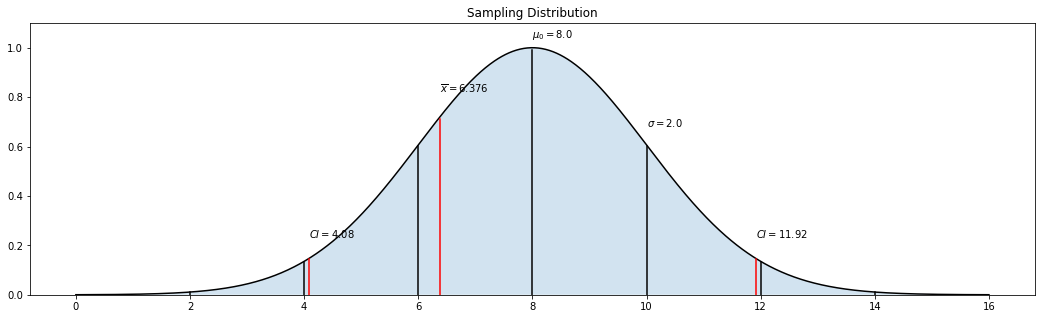

In [595]:
plotGauss(mu0, sigma, ci, mean, 'Sampling Distribution')

### One-sampled t-test
Is there a significant difference between a sample and a given population mean.

\begin{align} 
\overline{x} &= \frac{1}{n} \sum^n_{i=1}{x_i}\\
s &= \sqrt{\frac{ \sum^n_{i=1}{(x_i - \overline{x})^2} }{n-1}} \\
t &= \frac{  {\overline{x} - \mu_0}}{^{S}/_{\sqrt{n-1}}}
\end{align}

In [596]:
sample = norm.rvs(loc=5.5, scale=2, size=15)
n, mean, sd = len(sample), np.mean(sample), np.std(sample)
mu0 = 6
print mean, sd
print sample

5.84231181955 1.86922992696
[  4.11700106   4.11262217  10.7674318    6.3935198    6.302975
   5.72252471   6.10466742   7.76943479   7.44936677   3.70189993
   5.61248539   5.99654411   2.62725459   5.60097035   5.3559794 ]


In [597]:
se = sd / np.sqrt(n-1)
T = (mean - mu0) / se
p = t.cdf(T, n-1)*2
ci = np.array(t.interval(.95, n-1))
print T, p, ci
print ttest_1samp(sample, mu0)

-0.315646104682 0.756927433104 [-2.14478669  2.14478669]
Ttest_1sampResult(statistic=-0.31564610468201687, pvalue=0.7569274331040422)


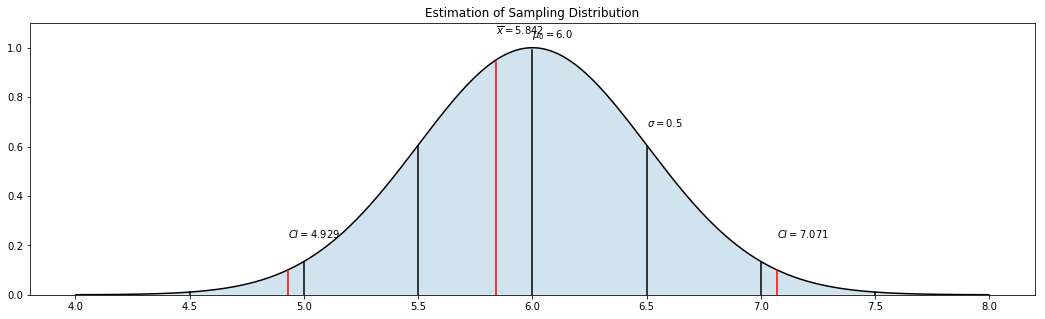

In [598]:
plotGauss(mu0, se, ci, mean, 'Estimation of Sampling Distribution')

### Paired sampled t-test
Is there a significant difference between dependent samples.

\begin{align}
x_i &= y_i - z_i\\
\overline{x} &= \frac{1}{n} \sum^n_{i=1}{x_i}\\
s &= \sqrt{\frac{ \sum^n_{i=1}{(x_i - \overline{x})^2} }{n-1}} \\
s_e &= \frac{s}{\sqrt{n-1}}\\
t &= \frac{  {\overline{x} - \mu_0}}{s_e}
\end{align}

In [599]:
sample1 = norm.rvs(loc=5.8, scale=2, size=15)
sample2 = norm.rvs(loc=6.1, scale=2, size=15)
sample = sample1 - sample2
n, mean, sd = len(sample), np.mean(sample), np.std(sample)
mu0 = 0 # No difference
print mean, sd
print sample

-0.503482257891 2.10500189376
[-3.45425861  1.54051458 -3.05301935 -0.55076011 -0.19591383  2.65427066
  3.87503444 -2.70474944 -1.61690405  0.88860837 -0.34419109 -1.03766927
  0.03401631 -0.07764734 -3.50956515]


In [600]:
se = sd / np.sqrt(n-1)
T = (mean - mu0) / se
p = t.cdf(T, n-1)*2
ci = np.array(t.interval(.95, n -1))
print T, p, ci
print ttest_rel(sample1, sample2)

-0.894943664864 0.385945450746 [-2.14478669  2.14478669]
Ttest_relResult(statistic=-0.8949436648642104, pvalue=0.38594545074606412)


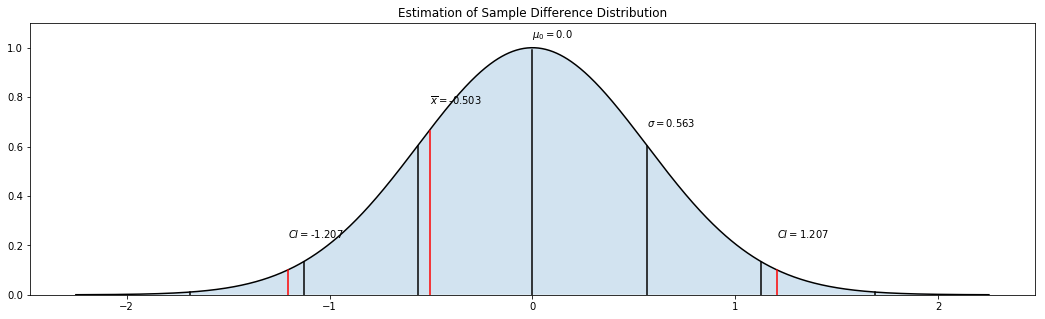

In [601]:
plotGauss(mu0, se, ci, mean, 'Estimation of Sample Difference Distribution')

### Two sample t-test
Is there a significant difference between independent samples.

\begin{align}
\overline{x} &= \frac{1}{n} \sum^n_{i=1}{x_i}&\overline{y} &= \frac{1}{m} \sum^n_{i=1}{y_i}\\
s_x &= \sqrt{{\frac{ \sum^n_{i=1}{(x_i - \overline{x})^2} }{n-1}}} & s_y &= \sqrt{{\frac{ \sum^m_{i=1}{(y_i - \overline{y})^2} }{m-1}}} \\
s_e &= \sqrt{\frac{(n-1)s^2_x + (m-1)s^2_y}{n+m-2} * \left(\frac{1}{n}+\frac{1}{m}\right)}\\
t &= \frac{  {\overline{x} - \overline{y}}} {s_e}
\end{align}

In [602]:
sample1 = norm.rvs(loc=5.8, scale=2, size=15)
sample2 = norm.rvs(loc=6.1, scale=2, size=10)
n, mean1, sd1 = len(sample1), np.mean(sample1), np.std(sample1)
m, mean2, sd2 = len(sample2), np.mean(sample2), np.std(sample2)
mu0 = 0
print mean1, sd1, mean2, sd2
print sample1
print sample2

6.1725615853 2.18598365138 6.3529246715 1.42840146358
[  4.75757455   8.15846658   2.79533961   7.24909203   5.3928382
  10.48921624   2.32901968   6.58986964   6.93321492   9.08247218
   7.13093763   5.65891725   7.15607664   5.36242872   3.50295991]
[ 7.57066032  7.49129027  5.85088436  6.83272575  6.64284954  5.51365296
  2.51932833  7.03222494  7.39684466  6.67878559]


In [603]:
se = np.sqrt(((n-1) * np.power(sd1, 2) + (m-1) * np.power(sd2, 2)) / (n + m - 2) * (1/float(n)+1/float(m)))
T = (mean1 - mean2) / se
p = t.cdf(T, n+m-2)*2
ci = np.array(t.interval(.95, n + m - 2))
print T, p, ci
print ttest_ind(sample1, sample2)

-0.229460865972 0.820539025349 [-2.06865761  2.06865761]
Ttest_indResult(statistic=-0.22080137534963587, pvalue=0.82719543727589095)


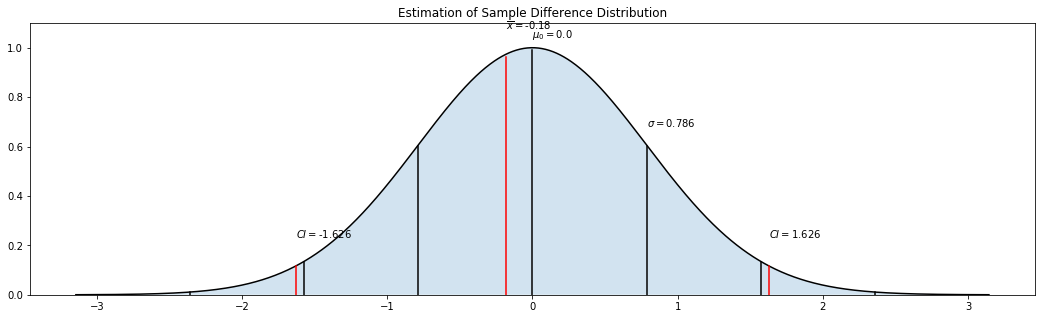

In [604]:
plotGauss(mu0, se, ci, mean1 - mean2, 'Estimation of Sample Difference Distribution')